# Machine Learning 

## Linear & Polynomial regression

### Bike-sharing

## Στόχος

Στόχος μας είναι να προβλέψουμε το πλήθος των ενοικιάσεων ποδηλάτων με τα διαθέσιμα χαρακτηριστικά των ημερών και συγκεκριμένα με την ημέρα (ποια ημέρα της εβδομάδας είναι, αν είναι εργάσιμη ή αργία, σε ποιο μήνα είναι και ποια εποχή) και τις καιρικές συνθήκες.

##1. Εισαγωγή βιβλιοθηκών και δεδομένων

#### 1.1. Εισαγωγή των απαραίτητων πακέτων και βιβλιοθηκών 

In [32]:
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

#### 1.2. Εισαγωγή δεδομένων 

Data file: day.csv (https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)

Original Source: http://capitalbikeshare.com/system-data

Weather Information: http://www.freemeteo.com

Holiday Schedule: http://dchr.dc.gov/page/holiday-schedule

Get Started: 3 Ways to Load CSV files into Colab (https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92#:~:text=After%20you%20allow%20permission%2C%20copy,a%20string%20variable%20in%20Colab).

In [33]:
# Εισαγωγή του csv από το local drive
#from google.colab import files
#uploaded = files.upload()

In [34]:
# Εισαγωγή του csv από το github
url = 'https://raw.githubusercontent.com/tsparaskevas/ML_EDDE3/main/Linear%20%26%20Polynomial%20regression/Bike-rentals/day.csv'
bikedays_df = pd.read_csv(url)
bikedays_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


####1.3. Επισκόπηση και κατανόηση των δεδoμένων

In [35]:
# Εισαγωγή του csv σε dataframe
#import io
#bikedays_df = pd.read_csv(io.BytesIO(uploaded['day.csv']))

In [36]:
# Επισκόπηση του μεγέθους (αριθμός γραμμών και στηλών) του dataframe
bikedays_df.shape

(731, 16)

In [37]:
# Επισκόπηση των περιεχομένων του dataframe
bikedays_df.keys()

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

(array([ 13.,  62.,  71.,  73., 122., 137.,  81.,  76.,  79.,  17.]),
 array([  22. ,  891.2, 1760.4, 2629.6, 3498.8, 4368. , 5237.2, 6106.4,
        6975.6, 7844.8, 8714. ]),
 <a list of 10 Patch objects>)

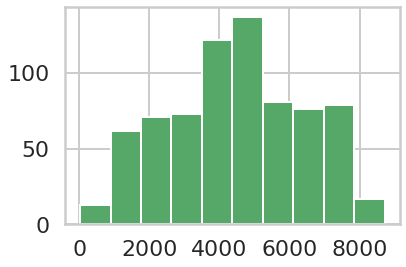

In [38]:
plt.hist(bikedays_df.cnt,color='g')

#####**Attribute Information:**
- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
 - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
 - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
 - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
 - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [39]:
# Μετονομασία των headers των στηλών
bikedays_df.rename(columns={"mnth":"month", "temp":"temperature",
                            "atemp":"feelingTemperature",
                            "hum":"humidity", "cnt":"rentals", "mnth":"month",
                            "weathersit":"weather"}, inplace=True)
# Αφαίρεση των στηλών του αύξοντα αριθμού, της ημερομηνίας, του έτους και των ευκαιριακών και εγγεγραμμένων χρηστών
# αφού αυτές οι μεταβλητές δεν μας ενδιαφέρουν 
bikedays_df = bikedays_df.drop(["instant", "dteday", "yr", "casual", "registered"],axis=1)

In [40]:
# Επισκόπηση των πρώτων 5 γραμμών
bikedays_df.head()

,season,month,holiday,weekday,workingday,weather,temperature,feelingTemperature,humidity,windspeed,rentals
0,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


####1.4. Διαχείριση των τιμών που λείπουν

In [41]:
# Έλεγχος για missing values
bikedays_df.isnull().sum()

season                0
month                 0
holiday               0
weekday               0
workingday            0
weather               0
temperature           0
feelingTemperature    0
humidity              0
windspeed             0
rentals               0
dtype: int64

In [42]:
# ορίζουμε τις τιμές που λείπουν
#missing_values = ["n/a", "na", "--", 999,9999]   
# τις αλλάζουμε όνομα
#bikedays_df.replace(to_replace = missing_values, value = np.nan, inplace = True) 
# πετάμε τις γραμμές με NaNs 
#bikedays_df.dropna(inplace=True) 
# Ξαναφέρνουμε το index στη σωστή σειρά, πάντα μετά από κόψιμο και πέταμα στηλών χρειάζεται reindex
#bikedays_df.reset_index(drop=True, inplace=True)  

In [43]:
# Aν χρειάζεται να πετάξουμε χειροκίνητα κάποια τιμή το κάνουμε ως εξής
# ls_lines_to_drop = [10]  
# bikedays_df.drop(ls_lines_to_drop, inplace=True) 
# bikedays_df.head()    

####1.5. Έλεγχος των δεδομένων
Exploratory Data Analysis is a very important step before training the model. In this section, we will use some visualizations to understand the relationship of the target variable with other features.

**Έλεγχος κανονικής κατανομής**

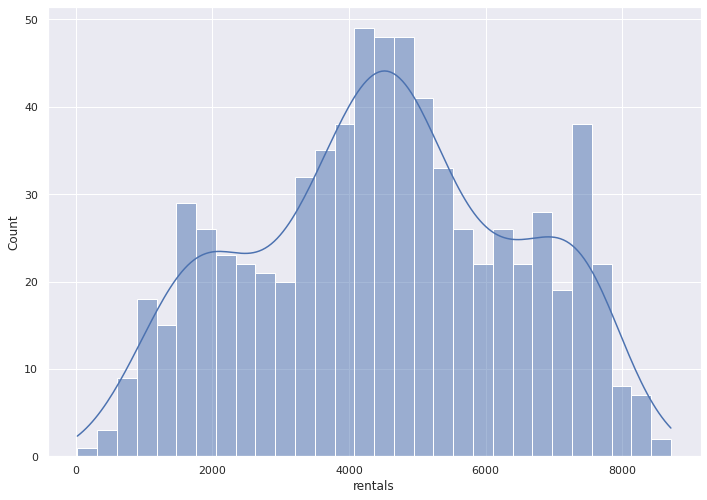

In [44]:
# Έλεγχος της κατανομής των ενοικιάσεων
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.histplot(bikedays_df['rentals'], bins=30, kde=True)
plt.show()

Οι τιμές των ενοικιάσεων ακολουθούν την κανονική κατανομή με μερικά outliers.

**Συγκεντρωτικά στατιστικά**

In [45]:
bikedays_df.describe()

,season,month,holiday,weekday,workingday,weather,temperature,feelingTemperature,humidity,windspeed,rentals
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,4504.348837
std,1.110807,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,1937.211452
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,22.000000
25%,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,3152.000000
50%,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,4548.000000
75%,3.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,5956.000000
max,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,8714.000000


**Έλεγχος συσχέτισης των μεταβλητών** 

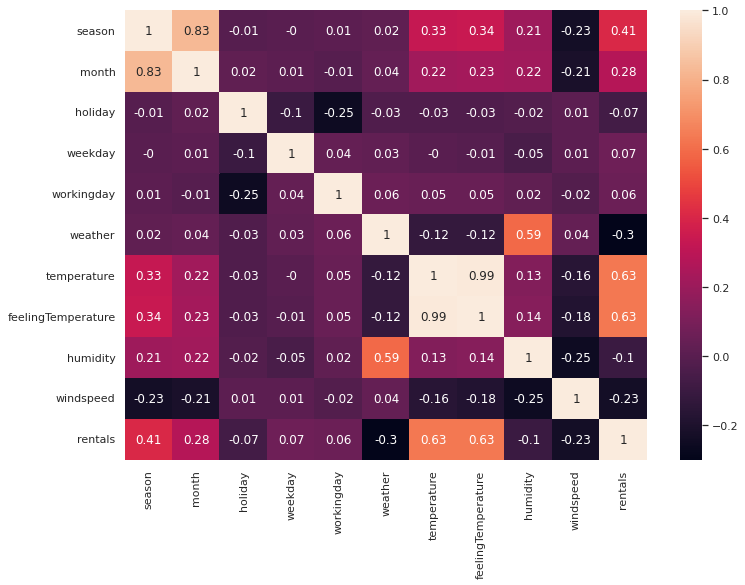

In [46]:
# Έλεγχος της συσχέτισης των μεταβλητών μεταξύ τους (συντελεστής γραμμικής συσχέτισης του Pearson ή δειγματικός συντελεστής συσχέτισης r)
# (το r είναι αξιόπιστο όταν οι τιμές των εξεταζόμενων μεταβλητών ακολουθούν κανονική κατανομή)
correlation_matrix = bikedays_df.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

Υπάρχει πολύ μεγάλη συσχέτιση μεταξύ της θερμοκρασίας και της αίσθησης της θερμοκρασίας (0.99) και μεταξύ της εποχής και του μήνα (0.83). Ωστόσο, η συσχέτιση των 2 μεταβλητών της θερμοκρασίας με τις ενοικιάσεις είναι ίδια (0.63, ενώ αντίθετα η επίδραση της εποχής στις ενοικιάσεις (0.41), φαίνεται μεγαλύτερη από την επίδραση του μήνα (0.28). Η υγρασία και το αν η μέρα είναι αργία ή ΣΚ ή εργάσιμη, φαίνεται ότι έχουν ελάχιστη επίδραση στις ενοικιάσεις (-0.1, -0.07, -0.07 και 0,06 αντίστοιχα).

**Έλεγχος των συσχετίσεων**

Με βάση τις παραπάνω παρατηρήσεις από το correlation matrix, εκτιμούμε ότι:
*   Από τις μεταβλητές "temperature" και "feelingTemperature" θα χρησιμοποιήσουμε μόνο την πρώτη
*   Η μεταβλητή "temperature" έχει τη σημαντικότερη συσχέτιση με τις ενοικιάσεις (0.63)
*   Κάποια σημαντική συσχέτιση με τις ενοικιάσεις έχουν επίσης οι μεταβλητές "season" (0.41), "weather" (0.3), "month" (0.28) και "windspeed" (-0.23)
*   Οι μεταβλητές "workingday" (0.06), "weekday" (0.07), "holiday" (-0.07) και "humidity" (-0.1) φαίνεται πως έχουν ελάχιστη ασήμαντη γραμμική συσχέτιση με τις ενοικιάσεις



**Scatterplots**

Θα φτιάξουμε μερικά scatterplots για να δούμε τον τρόπο συσχέτισης των βασικών χαρακτηριστικών της ημέρας με τις ενοικιάσεις ποδηλάτων.

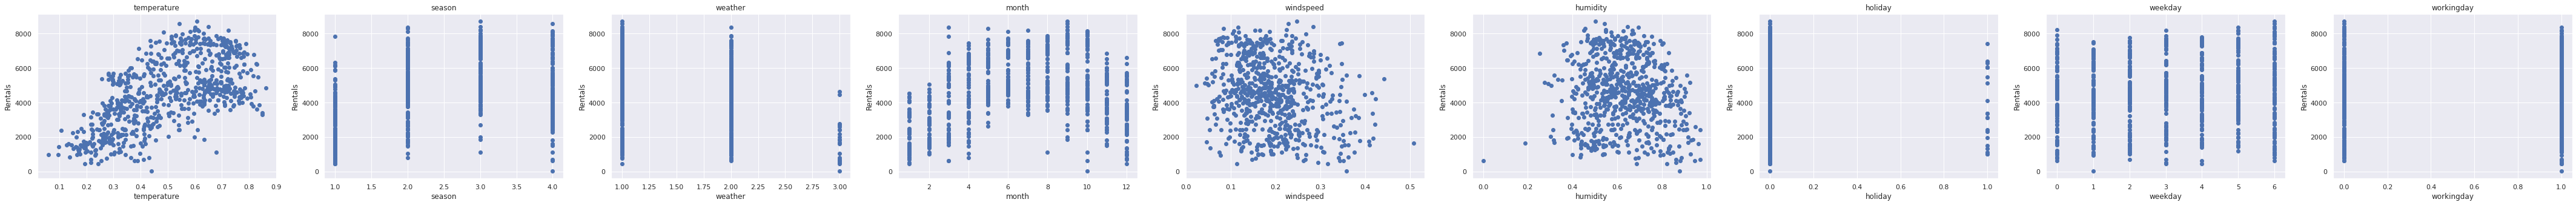

In [102]:
# Δημιουργία όλων των scatterplots
plt.figure(figsize=(75, 5))

features = ['temperature', 'season', 'weather', 'month', 'windspeed', 'humidity', 'holiday', 'weekday', 'workingday']
target = bikedays_df['rentals']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x_try = np.array(bikedays_df[col])
    y_try = np.array(target)
    x_try = x_try.reshape(-1,1)        # Reshape into 1D
    y_try = y_try.reshape(-1,1)        # Reshape into 1D
    plt.scatter(x_try, y_try, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('Rentals')

**Παρατηρήσεις**

*   Οι ενοικιάσεις αυξάνονται γραμμικά καθώς αυξάνεται η θερμοκρασία.
*   Οι ενοικιάσεις μειώνονται καθώς αυξάνονται η ταχύτητα του ανέμου και η υγρασία.
*   Ο μεγαλύτερος αριθμός ενοικιάσεων γίνεται τις μέρες του καλοκαιριού (3).
*   Ο μεγαλύτερος αριθμός ενοικιάσεων γίνεται με καλό καιρό (1), ενώ δεν γίνονται καθόλου ενοικιάσεις με βαριά βροχή (4).
*   Οι περισσότερες ενοικιάσεις και ο μεγαλύτερος αριθμός ενοικιάσεων γίνεται σε μέρες αργίας/διακοπών (0).
*   Ο μεγαλύτερος αριθμός ενοικιάσεων γίνεται την Κυριακή (μάλλον). Δεν ξεκαθαρίζεται πότε ξεκινάει η εβδομάδα: ΔΕ ή ΚΥ.
*   Οι ενοικιάσεις δεν φαίνεται να επηρεάζονται σημαντικά από το αν η ημέρα είναι εργάσιμη ή όχι.

Οι πλέον καθοριστικοί παράγοντες φαίνεται να είναι:
*   Η θερμοκρασία
*   Ο καιρός
*   Η εποχή
*   Ο μήνας
*   Το holiday
*   Η ημέρα της εβδομάδας



**!!! Σημείωση !!!**

Οι μεταβλητές των χαρακτηριστικών "temperature", "windspeed" και "humidity" είναι συνεχείς (scale), ενώ οι υπόλοιπες είναι ordinal.

H απλή γραμμική παλινδρόμηση αφορά μόνο συνεχείς μεταβλητές, αλλά παρακάτω φαίνεται πως το μοντέλο υπολογίζει καλά και τις ordinal. 

###2. Προετοιμασία των δεδομένων, training και evaluation με το μοντέλο Linear rigression

**Ορισμός του rentals ως target**

In [48]:
# Ορισμός του target
Y = np.array(bikedays_df.rentals)
Y = Y.reshape(-1,1)

Κάνουμε διάφορες δοκιμές με το μοντέλο Linear Regression με διαφορετικούς συνδυασμούς χαρακτηριστικών

**Training μόνο με το temperature**

TEMPERATURE ONLY
The model performance for training set
RMSE is 1521.0648663407878
R2 score is 0.37847585100128533
--------------------------------------
The model performance for testing set
RMSE is 1452.394099837426
R2 score is 0.44448948099964347


Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)


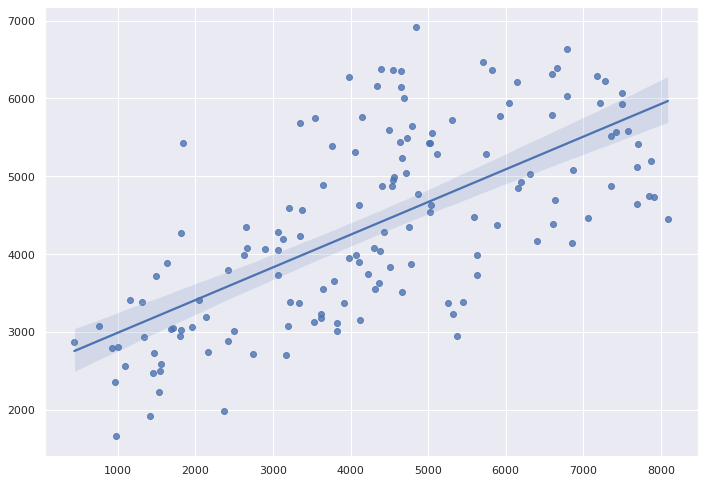

In [107]:
# Ορισμός του εξεταζόμενου χαρακτηριστικού (temperature)
Xtemp = np.array(bikedays_df.temperature)
Xtemp = Xtemp.reshape(-1,1)

# Διαχωρισμός των δεδομένων σε υποσύνολα για training και testing
X_train, X_test, Y_train, Y_test = train_test_split(Xtemp, Y, test_size = 0.2, random_state=5)

# Μοντέλο με regression
lin_model = LinearRegression()

# Εκπαίδευση στο training set
lin_model.fit(X_train, Y_train)

# Αξιολόγηση του μοντέλου για το training set
# Πρόβλεψη από το training set
y_train_pred = lin_model.predict(X_train) 
# Υπολογισμός root mean squared error
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_pred)))
# Υπολογισμός του r squared 
r2 = r2_score(Y_train, y_train_pred)

# Εκτύπωση αποτελεσμάτων αξιολόγησης training
print("TEMPERATURE ONLY")
print("The model performance for training set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("--------------------------------------")

# Αξιολόγηση του μοντέλου για το testing set
# Πρόβλεψη από το testing set
y_test_pred = lin_model.predict(X_test)
# Υπολογισμός root mean squared error
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_pred)))
# Υπολογισμός του r squared
r2 = r2_score(Y_test, y_test_pred)

# Εκτύπωση αποτελεσμάτων αξιολόγησης testing
print("The model performance for testing set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")
print("Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)")
sns.regplot(x=Y_test, y=y_test_pred)

**Training μόνο με το holiday**

HOLIDAY ONLY
The model performance for training set
RMSE is 1927.8230381517715
R2 score is 0.0016177083912490842
--------------------------------------
The model performance for testing set
RMSE is 1951.6329881254455
R2 score is -0.0030431946339586347


Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)


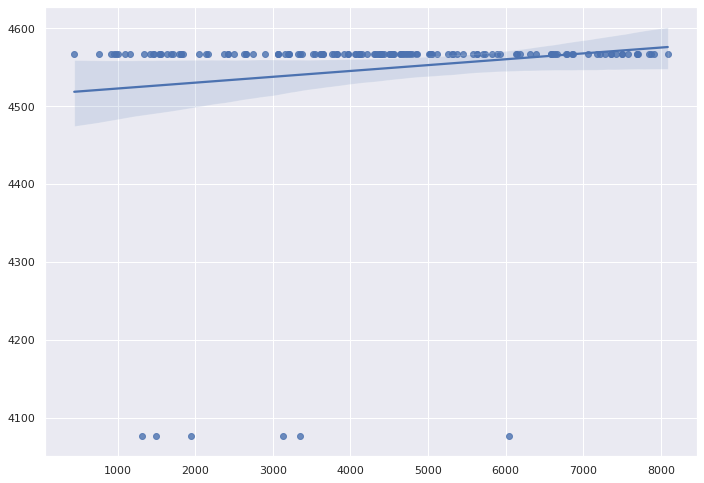

In [108]:
# Ορισμός του εξεταζόμενου χαρακτηριστικού (temperature)
Xtemp = np.array(bikedays_df.holiday)
Xtemp = Xtemp.reshape(-1,1)

# Διαχωρισμός των δεδομένων σε υποσύνολα για training και testing
X_train, X_test, Y_train, Y_test = train_test_split(Xtemp, Y, test_size = 0.2, random_state=5)

# Μοντέλο με regression
lin_model = LinearRegression()

# Εκπαίδευση στο training set
lin_model.fit(X_train, Y_train)

# Αξιολόγηση του μοντέλου στο training set
# Πρόβλεψη στο training set
y_train_pred = lin_model.predict(X_train) 
# Υπολογισμός του root mean squared error
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_pred)))
# Υπολογισμός του r squared 
r2 = r2_score(Y_train, y_train_pred)

# Εκτύπωση αποτελεσμάτων αξιολόγησης training
print("HOLIDAY ONLY")
print("The model performance for training set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("--------------------------------------")

# Αξιολόγηση του μοντέλου στο testing set
# Πρόβλεψη στο testing set
y_test_pred = lin_model.predict(X_test)
# Υπολογισμός του root mean square error
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_pred)))
# Υπολογισμός του r-squared
r2 = r2_score(Y_test, y_test_pred)

# Εκτύπωση αποτελεσμάτων αξιολόγησης testing
print("The model performance for testing set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")
print("Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)")
sns.regplot(x=Y_test, y=y_test_pred)

**Training μόνο με τα features του καιρού: temperature, windspeed, humidity και weather**

ONLY WEATHER FEATURES: TEMPERATURE, WINDSPEED, HUMIDITY & WEATHER
The model performance for training set
RMSE is 1413.9943397195639
R2 score is 0.46289662749283056
--------------------------------------
The model performance for testing set
RMSE is 1384.196511967302
R2 score is 0.4954330081068852


Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)


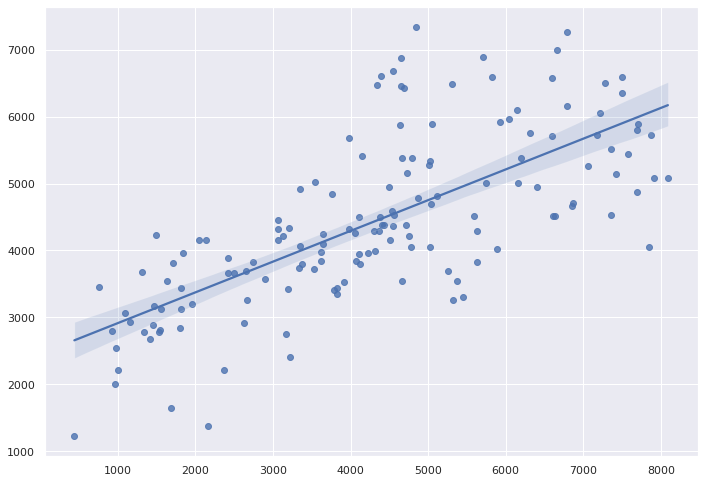

In [109]:
# Ορισμός των χαρακτηριστικών
X = pd.DataFrame(np.c_[bikedays_df['temperature'], bikedays_df['windspeed'], bikedays_df['humidity'], bikedays_df['weather']], columns = ['temperature', 'windspeed', 'humidity', 'weather'])

# Διαχωρισμός των δεδομένων σε υποσύνολα για training και testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

# Μοντέλο με regression
lin_model = LinearRegression()

# Εκπαίδευση στο training set
lin_model.fit(X_train, Y_train)

# Αξιολόγηση του μοντέλου στο training set
# Υπολογισμός της πρόβλεψης
y_train_pred = lin_model.predict(X_train) 
# Υπολογισμός του root mean squared error
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_pred)))
# υπολογισμός r squared 
r2 = r2_score(Y_train, y_train_pred)

# αποτελέσματα
print("ONLY WEATHER FEATURES: TEMPERATURE, WINDSPEED, HUMIDITY & WEATHER")
print("The model performance for training set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("--------------------------------------")

# model evaluation for testing set
y_test_pred = lin_model.predict(X_test)
# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_pred)))

# r-squared score of the model
r2 = r2_score(Y_test, y_test_pred)

print("The model performance for testing set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")
print("Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)")
sns.regplot(x=Y_test, y=y_test_pred)

**Training μόνο με τα features των ημερών: holiday, season, month, weekday και workingday**



ONLY DAY FEATURES: HOLIDAY, SEASON, MONTH, WEEKDAY & WORKINGDAY
The model performance for training set
RMSE is 1758.9596226400886
R2 score is 0.16885982025177804
--------------------------------------
The model performance for testing set
RMSE is 1715.9309894233163
R2 score is 0.22460504630822864


Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)


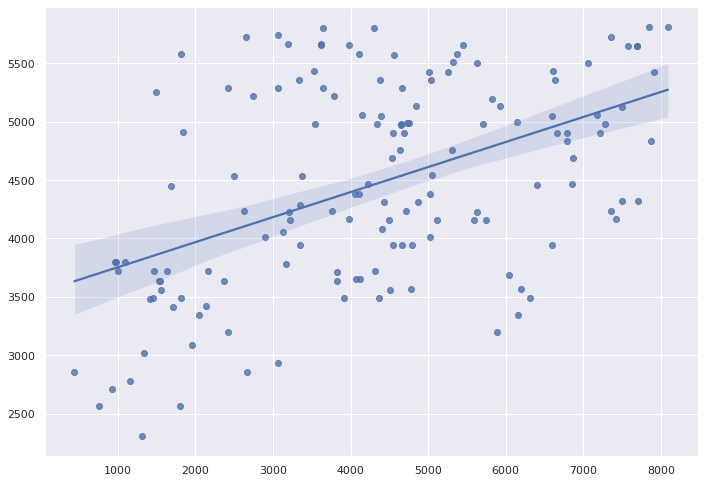

In [110]:
# Ορισμός των χαρακτηριστικών
X = pd.DataFrame(np.c_[bikedays_df['holiday'], bikedays_df['season'], bikedays_df['month'], bikedays_df['weekday'], bikedays_df['workingday']], columns = ['holiday', 'season', 'month', 'weekday', 'workingday'])

# Διαχωρισμός των δεδομένων σε υποσύνολα για training και testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

# Μοντέλο με regression
lin_model = LinearRegression()

# Εκπαίδευση
lin_model.fit(X_train, Y_train)

# model evaluation for testing set
y_train_pred = lin_model.predict(X_train) 
# υπολογισμός root mean squared error
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_pred)))
# υπολογισμός r squared 
r2 = r2_score(Y_train, y_train_pred)

# αποτελέσματα
print("ONLY DAY FEATURES: HOLIDAY, SEASON, MONTH, WEEKDAY & WORKINGDAY")
print("The model performance for training set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("--------------------------------------")

# model evaluation for testing set
y_test_pred = lin_model.predict(X_test)
# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_pred)))

# r-squared score of the model
r2 = r2_score(Y_test, y_test_pred)

print("The model performance for testing set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")
print("Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)")
sns.regplot(x=Y_test, y=y_test_pred)

**Training μόνο με τα features των ημερών χωρίς το workingday**



ONLY DAY FEATURES, NO WORKINGDAY
The model performance for training set
RMSE is 1759.1948643996511
R2 score is 0.16863749342849632
--------------------------------------
The model performance for testing set
RMSE is 1720.1307489356532
R2 score is 0.22080482651130962


Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)


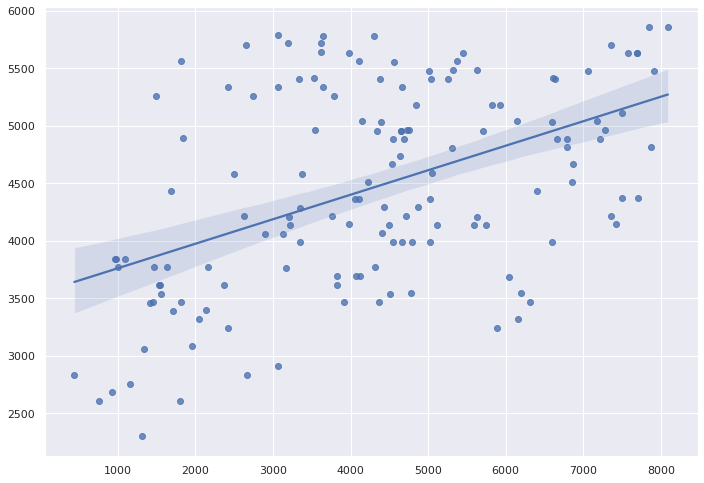

In [111]:
# Ορισμός των χαρακτηριστικών
X = pd.DataFrame(np.c_[bikedays_df['holiday'], bikedays_df['season'], bikedays_df['month'], bikedays_df['weekday']], columns = ['holiday', 'season', 'month', 'weekday'])

# Διαχωρισμός των δεδομένων σε υποσύνολα για training και testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

# Μοντέλο με regression
lin_model = LinearRegression()

# Εκπαίδευση
lin_model.fit(X_train, Y_train)

# model evaluation for testing set
y_train_pred = lin_model.predict(X_train) 
# υπολογισμός root mean squared error
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_pred)))
# υπολογισμός r squared 
r2 = r2_score(Y_train, y_train_pred)

# αποτελέσματα
print("ONLY DAY FEATURES, NO WORKINGDAY")
print("The model performance for training set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("--------------------------------------")

# model evaluation for testing set
y_test_pred = lin_model.predict(X_test)
# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_pred)))

# r-squared score of the model
r2 = r2_score(Y_test, y_test_pred)

print("The model performance for testing set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")
print("Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)")
sns.regplot(x=Y_test, y=y_test_pred)

**Training μόνο με τα: temperature, windspeed, humidity, holiday και weather**



ONLY SOME MAIN VARIABLES (temperature, windspeed, humidity, holiday, weather)
The model performance for training set
RMSE is 1412.8133803241637
R2 score is 0.46379342371847
--------------------------------------
The model performance for testing set
RMSE is 1371.2993827970554
R2 score is 0.5047917216192781


Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)


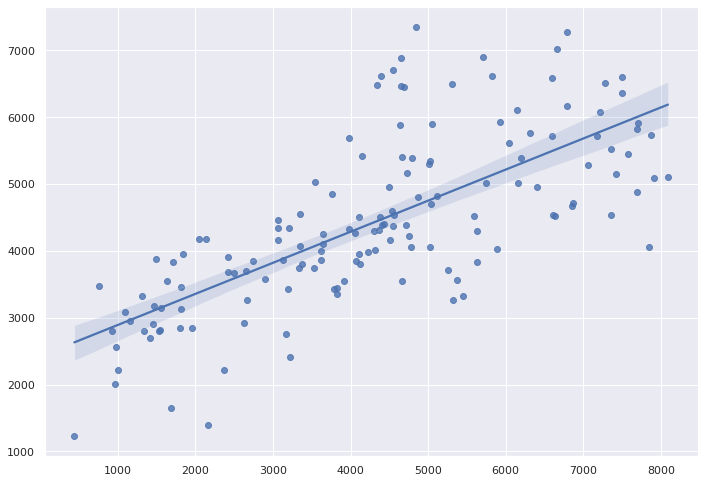

In [112]:
# Ορισμός όλων των χαρακτηριστικών
X = pd.DataFrame(np.c_[bikedays_df['temperature'], bikedays_df['windspeed'], bikedays_df['humidity'], bikedays_df['holiday'], bikedays_df['weather']], columns = ['temperature', 'windspeed', 'humidity', 'holiday', 'weather'])

# Διαχωρισμός των δεδομένων σε υποσύνολα για training και testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

# Μοντέλο με regression
lin_model = LinearRegression()

# Εκπαίδευση
lin_model.fit(X_train, Y_train)

# model evaluation for testing set
y_train_pred = lin_model.predict(X_train) 
# υπολογισμός root mean squared error
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_pred)))
# υπολογισμός r squared 
r2 = r2_score(Y_train, y_train_pred)

# αποτελέσματα
print("ONLY SOME MAIN VARIABLES (temperature, windspeed, humidity, holiday, weather)")
print("The model performance for training set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("--------------------------------------")

# model evaluation for testing set
y_test_pred = lin_model.predict(X_test)
# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_pred)))

# r-squared score of the model
r2 = r2_score(Y_test, y_test_pred)

print("The model performance for testing set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")
print("Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)")
sns.regplot(x=Y_test, y=y_test_pred)

**Training μόνο με τους φαινομενικά σημαντικότερους παράγοντες (temperature, weather, season, month, holiday, weekday)**

ONLY MAIN VARIABLES (temperature, season, weather, month, holiday, weekday)
The model performance for training set
RMSE is 1374.77120888142
R2 score is 0.49228102556100595
--------------------------------------
The model performance for testing set
RMSE is 1336.200724863711
R2 score is 0.5298171965557326


Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)


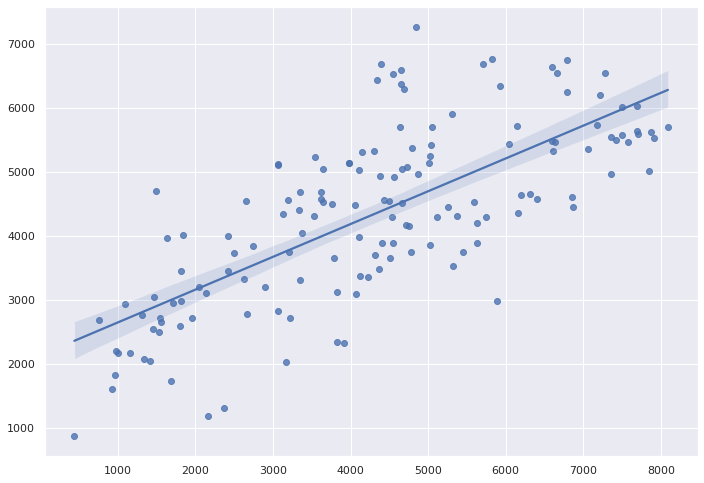

In [113]:
# Ορισμός όλων των χαρακτηριστικών
X = pd.DataFrame(np.c_[bikedays_df['temperature'], bikedays_df['season'], bikedays_df['weather'], bikedays_df['month'], bikedays_df['holiday'], bikedays_df['weekday']], columns = ['temperature', 'season', 'weather', 'month', 'holiday', 'weekday'])

# Διαχωρισμός των δεδομένων σε υποσύνολα για training και testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

# Μοντέλο με regression
lin_model = LinearRegression()

# Εκπαίδευση
lin_model.fit(X_train, Y_train)

# model evaluation for testing set
y_train_pred = lin_model.predict(X_train) 
# υπολογισμός root mean squared error
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_pred)))
# υπολογισμός r squared 
r2 = r2_score(Y_train, y_train_pred)

# αποτελέσματα
print("ONLY MAIN VARIABLES (temperature, season, weather, month, holiday, weekday)")
print("The model performance for training set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("--------------------------------------")

# model evaluation for testing set
y_test_pred = lin_model.predict(X_test)
# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_pred)))

# r-squared score of the model
r2 = r2_score(Y_test, y_test_pred)

print("The model performance for testing set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")
print("Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)")
sns.regplot(x=Y_test, y=y_test_pred)

**Training με όλα τα features**

ALL VARIABLES
The model performance for training set
RMSE is 1341.4295559577115
R2 score is 0.5166093125825537
--------------------------------------
The model performance for testing set
RMSE is 1307.580286522562
R2 score is 0.5497434245449645


Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)


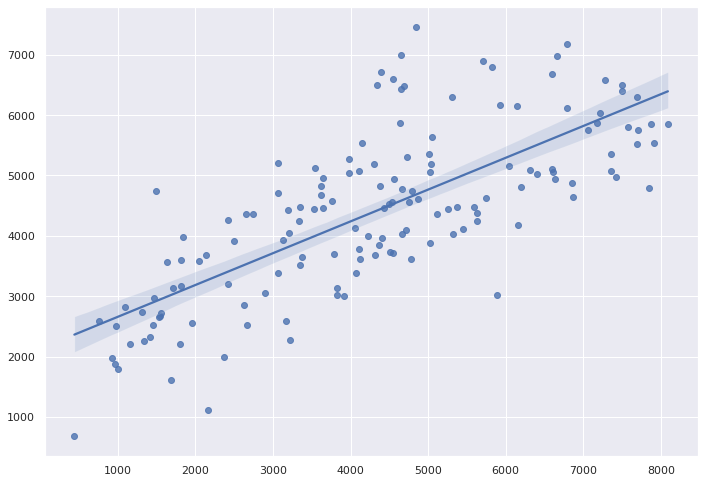

In [114]:
# Ορισμός όλων των χαρακτηριστικών
X = pd.DataFrame(np.c_[bikedays_df['temperature'], bikedays_df['season'], bikedays_df['weather'], bikedays_df['month'], bikedays_df['windspeed'], bikedays_df['humidity'], bikedays_df['holiday'], bikedays_df['weekday'], bikedays_df['workingday']], columns = ['temperature', 'season', 'weather', 'month', 'windspeed', 'humidity', 'holiday', 'weekday', 'workingday'])

# Διαχωρισμός των δεδομένων σε υποσύνολα για training και testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

# Μοντέλο με regression
lin_model = LinearRegression()

# Εκπαίδευση
lin_model.fit(X_train, Y_train)

# model evaluation for testing set
y_train_pred = lin_model.predict(X_train) 
# υπολογισμός root mean squared error
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_pred)))
# υπολογισμός r squared 
r2 = r2_score(Y_train, y_train_pred)

# αποτελέσματα
print("ALL VARIABLES")
print("The model performance for training set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("--------------------------------------")

# model evaluation for testing set
y_test_pred = lin_model.predict(X_test)
# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_pred)))

# r-squared score of the model
r2 = r2_score(Y_test, y_test_pred)

print("The model performance for testing set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")
print("Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)")
sns.regplot(x=Y_test, y=y_test_pred)

**ΣΥΜΠΕΡΑΣΜΑ**

Από τις παραπάνω δοκιμές, φαίνεται ότι η καλύτερη πρόβλεψη γίνεται με όλα τα features (R2 = 0.549), ενώ η πρόβλεψη μόνο με τα features του καιρού είναι λιγότερο αξιόπιστη (R2 = 0.495). Επίσης, παρατηρούμε ότι σε όλες τις δοκιμές, η πρόβλεψη είναι καλύτερη στο test από το train.

###Polynomial regression

**Function για το Polynomial regression**

In [115]:
from sklearn.preprocessing import PolynomialFeatures

def create_polynomial_regression_model(degree):
  "Creates a polynomial regression model for the given degree"
  
  poly_features = PolynomialFeatures(degree=degree)
  
  # transforms the existing features to higher degree features.
  X_train_poly = poly_features.fit_transform(X_train)
  
  # fit the transformed features to Linear Regression
  poly_model = LinearRegression()
  poly_model.fit(X_train_poly, Y_train)
  
  # predicting on training data-set
  y_train_predicted = poly_model.predict(X_train_poly)
  
  # predicting on test data-set
  y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
  
  # evaluating the model on training dataset
  rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
  r2_train = r2_score(Y_train, y_train_predicted)
  
  # evaluating the model on test dataset
  rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predict))
  r2_test = r2_score(Y_test, y_test_predict)
  
  print("ALL FEATURES - degree {}".format(degree))
  print("The model performance for the training set")
  print("RMSE of training set is {}".format(rmse_train))
  print("R2 score of training set is {}".format(r2_train))
  print("-------------------------------------------")  
  print("The model performance for the test set")
  print("RMSE of test set is {}".format(rmse_test))
  print("R2 score of test set is {}".format(r2_test))
  print("\n")
  print("Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)")
  sns.regplot(x=Y_test, y=y_test_pred)

####Polynomial regression με όλα τα features

**Κλήση του function για Polynomial regression, με degree = 2**

ALL FEATURES - degree 2
The model performance for the training set
RMSE of training set is 1145.25575861759
R2 score of training set is 0.6476554925954168
-------------------------------------------
The model performance for the test set
RMSE of test set is 1294.9995295027536
R2 score of test set is 0.5583659436845838


Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)


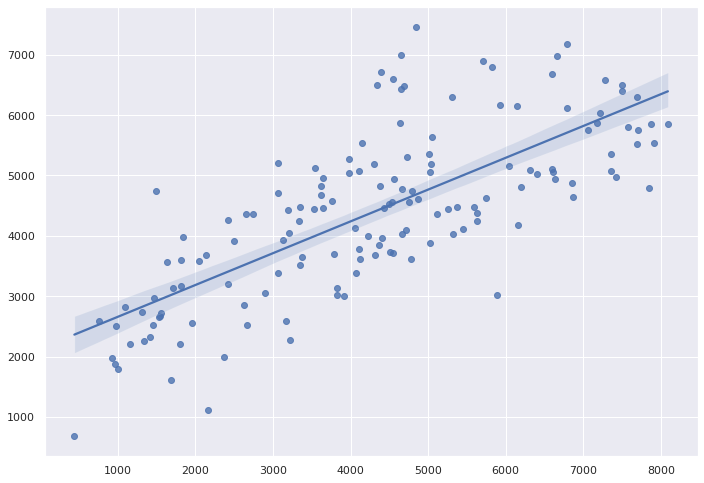

In [116]:
create_polynomial_regression_model(2)

**Κλήση του function για Polynomial regression, με degree = 3**

ALL FEATURES - degree 3
The model performance for the training set
RMSE of training set is 972.6220890028916
R2 score of training set is 0.7458730088685727
-------------------------------------------
The model performance for the test set
RMSE of test set is 2388.4489701827247
R2 score of test set is -0.5022951628718546


Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)


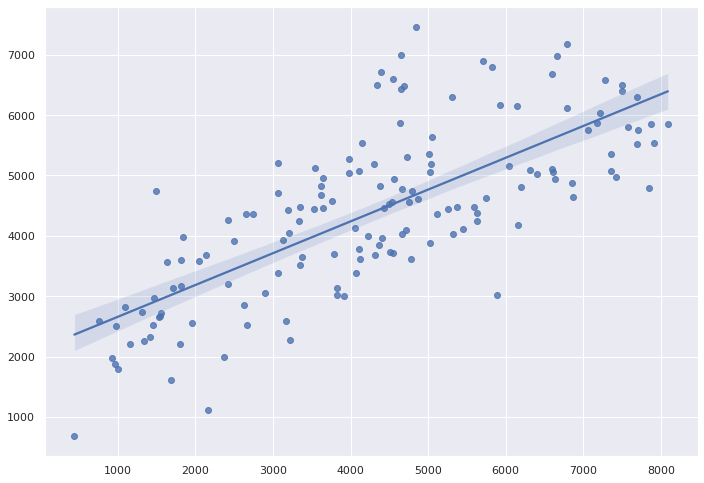

In [117]:
create_polynomial_regression_model(3)

**ΣΥΜΠΕΡΑΣΜΑ**

Με όλα τα χαρακτηριστικά, το Polynomial regression δίνει τα καλύτερα αποτελέσματα με degree=2. Το αποτέλεσμα αυτό (R2 = 0.558) στο test set είναι λίγο καλύτερο από το αποτέλεσμα (R2 = 0.549) με το Linear regression.

Παρατηρούμε επίσης ότι άσχετα με το degree, το αποτέλεσμα με Plynomial regression για το train set είναι καλύτερο από το αποτέλεσμα για το test set.

####Polynomial regression ΜΟΝΟ με τα features του καιρού

**Linear regression με τα features του καιρού**

In [90]:
# Ορισμός των χαρακτηριστικών
X = pd.DataFrame(np.c_[bikedays_df['temperature'], bikedays_df['windspeed'], bikedays_df['humidity'], bikedays_df['weather']], columns = ['temperature', 'windspeed', 'humidity', 'weather'])

# Διαχωρισμός των δεδομένων σε υποσύνολα για training και testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

# Μοντέλο με regression
lin_model = LinearRegression()

# Εκπαίδευση
lin_model.fit(X_train, Y_train)

# model evaluation for testing set
y_train_pred = lin_model.predict(X_train) 
# υπολογισμός root mean squared error
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_pred)))
# υπολογισμός r squared 
r2 = r2_score(Y_train, y_train_pred)

# αποτελέσματα
print("ONLY WEATHER FEATURES: TEMPERATURE, WINDSPEED, HUMIDITY & WEATHER")
print("The model performance for training set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("--------------------------------------")

# model evaluation for testing set
y_test_pred = lin_model.predict(X_test)
# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_pred)))

# r-squared score of the model
r2 = r2_score(Y_test, y_test_pred)

print("The model performance for testing set")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

ONLY WEATHER FEATURES: TEMPERATURE, WINDSPEED, HUMIDITY & WEATHER
The model performance for training set
RMSE is 1413.9943397195639
R2 score is 0.46289662749283056
--------------------------------------
The model performance for testing set
RMSE is 1384.196511967302
R2 score is 0.4954330081068852




**Κλήση του function για Polynomial regression, με degree = 2**

ALL FEATURES - degree 2
The model performance for the training set
RMSE of training set is 1224.1344159190342
R2 score of training set is 0.5974491448427528
-------------------------------------------
The model performance for the test set
RMSE of test set is 1262.6360879681724
R2 score of test set is 0.5801639465180362




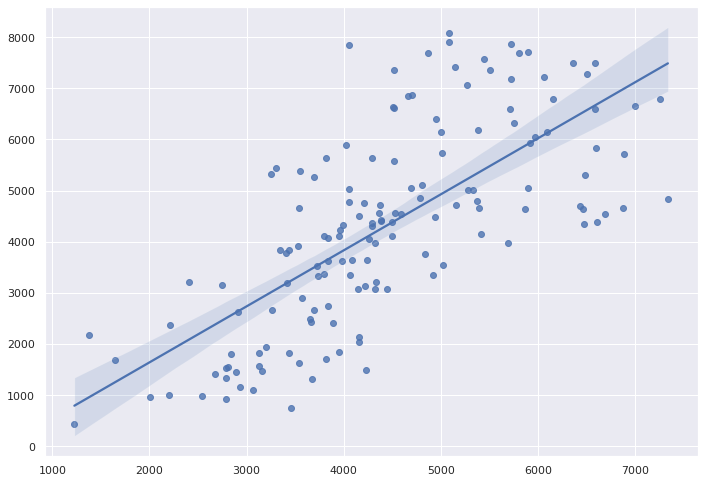

In [91]:
create_polynomial_regression_model(2)

**Κλήση του function για Polynomial regression, με degree = 3**

ALL FEATURES - degree 3
The model performance for the training set
RMSE of training set is 972.6220890028916
R2 score of training set is 0.7458730088685727
-------------------------------------------
The model performance for the test set
RMSE of test set is 2388.4489701827247
R2 score of test set is -0.5022951628718546


Γραφική απεικόνιση της σχέσης των πραγματικών ενοικιάσεων (Χ) με τις προβλεπόμενες ενοικιάσεις (Υ)


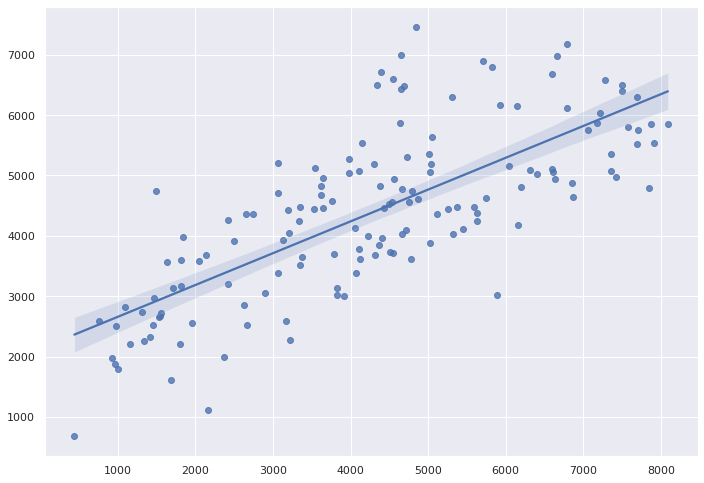

In [118]:
create_polynomial_regression_model(3)

**ΣΥΜΠΕΡΑΣΜΑ**

ΜΟΝΟ με τα χαρακτηριστικά του καιρού, το Polynomial regression δίνει και πάλι τα καλύτερα αποτελέσματα με degree=2. Το αποτέλεσμα αυτό (R2 = 0.580) στο test set είναι λίγο καλύτερο από το αποτέλεσμα (R2 = 0.495) με το Linear regression.

Παρατηρούμε επίσης και πάλι, ότι άσχετα με το degree, το αποτέλεσμα με Plynomial regression για το train set είναι καλύτερο από το αποτέλεσμα για το test set.